# Marketing Mix Model

**Sanofi**

-Author: Patricio Fernández

- Dependencies
    - Optuna library (for optimization).
    - Pandas
    - Matplotlib
    - Sklearn
    - Plotly 

## Objective of this Notebook 

This notebook serves as a guide on how to build marketing mix models in order to obtain contributions of the different channels (touchpoints) on product sales. This toy example includes relevant feature transformations as adstock (decay), seasonality, saturation, lags, etc. 

Likewise, it has been built with toy data which mimics real-life scenarios, but is not a full picture of the marketing spends a real product has during a year.

## 1. initialize notebook and Setup

In [ ]:
# Install optuna for non linear optimization. Plotly for VIZ 
#!pip install optuna
#!pip install plotly

In [1]:
# Imports.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.linear_model import LinearRegression, Ridge
import optuna
from scipy.interpolate import make_interp_spline
import plotly.express as px


In [2]:
# Configuration for viz and verbosity.
plt.rcParams["figure.figsize"] = (20,8)
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Path were the input file is stored.
data_url = "https://raw.githubusercontent.com/patofw/sanofi_use_cases/main/Data/contribution_exercise.csv"
# Define channels to use.
CHANNELS = ['tv_1', 'tv_2', 'tv_3', 'promo', 'onsite']

# Define target variable.
TARGET = 'sales'
# Define weeks for testing period.
TEST_SIZE = 8
# Seed for reproducibility
SEED = 42

# COVID FLAG (Stocking)
start_date = '16-03-2020'
end_date = '01-04-2020'

# 2. Helpers

In [3]:
# Helpers
# Data process .
def _date_is_between(x, low, high) -> bool:

    x = pd.to_datetime(x, format='%d-%m-%Y')
    low = pd.to_datetime(low, format='%d-%m-%Y')
    high = pd.to_datetime(high, format='%d-%m-%Y')

    if x >= low and x <= high:
        return 1
    else:
        return 0

def add_flag(
    df: pd.DataFrame,
    flag_name: str = 'flag',
    start_date: str = start_date,
    end_date: str = end_date,
    ):
    # add flag
    df[flag_name] = df.Date.apply(lambda x: 
        _date_is_between(
            x, start_date, end_date
        )
    )

def add_monthly_seasonality(
    pdf_input: pd.DataFrame
) -> pd.DataFrame:
    "Adds monthly seasonality as one hot encoded variables"
    pdf = pdf_input.copy()
    pdf['Date'] = pd.to_datetime(pdf.Date)
    # Create col for month.
    pdf['month'] = pdf.Date.dt.month
    # Add one hot encoding. Remove last column due to redundancy.
    pdf_seasonal = pd.concat(
        [
            pdf,
            pd.get_dummies(
                pdf['month'], 
                prefix='month'
            ).iloc[:, :-1]
        ],
        axis=1
    )
    
    return  pdf_seasonal.drop('month', axis=1)

# Carry over, Saturation helpers.

def carry_over_effect(
    input_variable: pd.Series, decay: float, lag: int
) -> pd.Series:
    "Apply carry over transformation to a given pandas Series"
    output = []
    for row in range(len(input_variable)):
        # Take care of observations with less days than required for lags. 
        # e.g. For the first day, we have a problem if lag=5.
        lag_aux = min(lag, row)
        
        # Apply decay effect to every row.
        output.append(
            sum(
                [
                    input_variable[row-i] * (decay ** i)  for i in range(lag_aux + 1)
                ]
            )
        )
    return pd.Series(output)

def saturation_effect(input_variable: pd.Series, alpha: float
) -> pd.Series:
    "Apply exponential transformation to a given pandas Series."
    return (1 - np.exp(-alpha * input_variable))

def adstock_tranformation(
    input_variable: pd.Series, alpha: float, decay: float, lag: int
) -> pd.Series:
    "Apply adstock transformation to a given pandas Series."
    return saturation_effect(
        carry_over_effect(
            input_variable, decay, lag
        ), alpha
    )

def add_adstock_to_pdf(
    pdf_input: pd.DataFrame,
    hyperparameters: dict,
    channels: list,
) -> pd.DataFrame:
    "Add adstock columns to a given dataset."
    
    pdf = pdf_input.copy()
    # Add a column for each channel with the name adstock_channel.
    for c in channels:
        pdf[f'adstock_{c}'] = adstock_tranformation(
            pdf[c],
            hyperparameters[f'alpha_{c}'],
            hyperparameters[f'decay_{c}'],
            hyperparameters[f'lag_{c}']
            ).values
    return pdf

def sales_from(
    channel: str,
    features: list,
    model: LinearRegression,
    X: pd.DataFrame
    ) -> pd.DataFrame:
    "Compute sales attributed to a certain channel"
    coef = model.coef_[features.index(channel)]
    obs = X.iloc[:, features.index(channel)]
    return  coef * obs

## 3. Process data

Here we have data for sales and marketing spends for different channels. For every marketing channel, we have multiple subchannels (for example, in TV there are 3 different subchannels and in promo events and on site trade, we encounter different locations and targets).

For this, we decided to model our sales variable as a function of every tv subchannel, events and onsite marketing.

Finally, we will work with weekly granularity, allocating promo eventsm TV and onsite marketing evenly distributed for every week in the month.

In [4]:
pdf_processed = pd.read_csv(data_url)
# Adds OHE seasonalit variables.
pdf_processed = add_monthly_seasonality(pdf_processed)
# Add covid Stocking flag
add_flag(
    pdf_processed, 
    'covid_flag',
     start_date, 
     end_date
)
# Having date as index for handling
pdf_processed.set_index('Date', inplace=True)
# check it 
pdf_processed.head()

,sales,tv_1,tv_2,tv_3,promo,onsite,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,covid_flag
Date,,,,,,,,,,,,,,,,,,
2019-01-13,2333.774722,605.0,125.0,37.381706,12.514645,1158.023548,1,0,0,0,0,0,0,0,0,0,0,0
2019-01-20,2140.697120,508.0,167.0,34.766218,12.514645,1158.023548,1,0,0,0,0,0,0,0,0,0,0,0
2019-01-27,2485.883420,0.0,166.0,46.756001,12.514645,1158.023548,1,0,0,0,0,0,0,0,0,0,0,0
2019-02-03,2777.820794,0.0,191.0,47.218405,8.999762,1138.811742,0,1,0,0,0,0,0,0,0,0,0,0
2019-02-10,2875.494071,0.0,158.0,44.303406,4.313250,1113.196000,0,1,0,0,0,0,0,0,0,0,0,0


In [5]:
# Plot it
px.line(pdf_processed.sales)

In [6]:
# PLot channel spend for month
fig = px.bar(
    pdf_processed, 
    x=pdf_processed.index, 
    y=CHANNELS, 
    title="Channel Spend per Date"
)
fig.show()

## 4. Adstock modeling.

In this section we add (i) carry over and (ii) saturation effects.

We want to model the relationship of the different investment channels using a linear regression, however we want to take into account the [decay effect](https://en.wikipedia.org/wiki/Advertising_adstock#Advertising_lag:_decay_effect) and the [law of diminishing returns](https://en.wikipedia.org/wiki/Advertising_adstock#Campaign_carry-over).

---
For this, instead of working directly with spend per channel, we apply different transformations to them

> 1. For carry over $c_{t}$, we apply the following transformation.
$$c_{t} = x_{t} + \sum_{j=1}^{n} \lambda^{t}  x_{t-j}$$
>
> Where $x_{t}$ is the investment in the channel for the $t$ period, $n$ represents the amount of periods to look back and $\lambda$ represents the strength or decay factor. Both $n$ and $\lambda$ will be parameters of the function.
><br/>
><br/>
>2. For the saturation effect $s_{t}$, the following transformation is applied.
>
>$$s_{t} =1 -  e^{-\alpha x_{t}} $$
>
> In this case, $\alpha$ will be a parameter to input.

<br/>

In consequence, instead of modeling sales as a function of investment per channel, we fit a regression to the transformations described previously. The question now is which values should we use for **$n$, $\lambda$ and $\alpha$**? We can think of them as *hyperparameters of our model*. And then perform a *numerical optimization* to find values that minimize the mean squared error (or any metric of our interest) of the model.
<br/>


Lastly, data presents a heavy seasonality, one hot encoded variables were added for every month in the year.

---

For a complete explanation of the methods used in here, we refer the reader to page *154/510* of [Introduction to Algorithmic Marketing](https://algorithmicweb.files.wordpress.com/2018/07/algorithmic-marketing-ai-for-marketing-operations-r1-7g.pdf).


## 5. Fit model.

### Tune hyperparameters

- We use optuna for hyperparameter tuning, but other libraries like `scipy.minimize` should work as well.
- For every channel, we have three ($\alpha$, $n$ and $\lambda$) hyperparameters to tune.
- We work with a Ridge regression to account for (possible) overfitting.
- We aim to minimize *MSE*.
- We repeat 2000 trials for the optimization, caution! can take some time. Feel free to change `n_trials=100` to speed things up.
- We split the dataset in train and test. Since we are working with time series we work with consecutives chunks of data. We define `test_size=24` weeks

In [7]:
# Split data for train test.
pdf_train = pdf_processed.iloc[:-TEST_SIZE, :]
pdf_test = pdf_processed.iloc[-TEST_SIZE:, :]

# Define features and target variable.
features = [
    c for c in list(pdf_processed) if 'month' in c or 'flag' in c
] + [f'adstock_{c}' for c in CHANNELS]

In [8]:
# Usually helpers should be at the top of the notebook, but we put this one here
# as it is a dictionary with multiple values to configure and play around with.

def objective_tune_params(trial, df: pd.DataFrame = pdf_train):

    hyperparameters = {
        'alpha_tv_1': trial.suggest_float('alpha_tv_1', 0, 0.1),
        'decay_tv_1': trial.suggest_float('decay_tv_1',  0, 0.5),
        'lag_tv_1': trial.suggest_int('lag_tv_1', 0, 6),
        'alpha_tv_2': trial.suggest_float('alpha_tv_2', 0, 0.1),
        'decay_tv_2': trial.suggest_float('decay_tv_2',  0, 0.5),        
        'lag_tv_2': trial.suggest_int('lag_tv_2', 0, 6),
        'alpha_tv_3': trial.suggest_float('alpha_tv_3', 0, 0.1),
        'decay_tv_3': trial.suggest_float('decay_tv_3',  0, 0.5),
        'lag_tv_3': trial.suggest_int('lag_tv_3', 0, 6),
        'alpha_onsite': trial.suggest_float('alpha_onsite', 0, 0.1),
        'decay_onsite': trial.suggest_float('decay_onsite', 0, 0.5),
        'lag_onsite': trial.suggest_int('lag_onsite', 0, 3),
        'alpha_promo': trial.suggest_float('alpha_promo', 0, 0.1),
        'decay_promo': trial.suggest_float('decay_promo', 0, 0.5),
        'lag_promo': trial.suggest_int('lag_promo', 0, 5)
    }
    # Add adstock variables
    pdf_adstock = add_adstock_to_pdf(df, hyperparameters, CHANNELS)

    # Define X and y.  
    X = pdf_adstock[features]
    y = pdf_adstock[TARGET]
    
    # Initialize regression class.
    #lr = Ridge()
    lr = LinearRegression()
    
    # Fit model and compute error (mean squared error).
    lr.fit(X ,y)
    y_hat = lr.predict(X)
    return np.mean((y - y_hat) ** 2)

In [9]:
# Perform the optimization.
study_tune_params = optuna.create_study(
    sampler=optuna.samplers.RandomSampler(seed=SEED)
)
study_tune_params.optimize(objective_tune_params, n_trials=1000)

### Run final model.
With tuned hyperparameters, we train the final model.

In [10]:
# Check optimized params.
study_tune_params.best_params

{'alpha_tv_1': 0.03463635031084943,
 'decay_tv_1': 0.29968961113055087,
 'lag_tv_1': 6,
 'alpha_tv_2': 0.01670417813381526,
 'decay_tv_2': 0.35882279317137133,
 'lag_tv_2': 5,
 'alpha_tv_3': 0.008897553586933837,
 'decay_tv_3': 0.4306246925915325,
 'lag_tv_3': 5,
 'alpha_onsite': 0.003340300657743445,
 'decay_onsite': 0.04554220744002574,
 'lag_onsite': 0,
 'alpha_promo': 0.033474353179936224,
 'decay_promo': 0.2546444953399631,
 'lag_promo': 3}

In [11]:
# Best set of hyperparameters.
hyperparameters = study_tune_params.best_params

# We replicate adstock transformation, train test splitting and model fitting. 
# Add adstock columns. 
pdf_adstock_train  = add_adstock_to_pdf(pdf_train,hyperparameters, CHANNELS) 
pdf_adstock_test = add_adstock_to_pdf(pdf_test, hyperparameters, CHANNELS)

# Define train and test data.
X_train, y_train = pdf_adstock_train[features], pdf_adstock_train[TARGET]
X_test, y_test = pdf_adstock_test[features], pdf_adstock_test[TARGET]

# Initialize model.
lr = LinearRegression()

lr.fit(X_train, y_train)

LinearRegression()

## 6. Model performance.

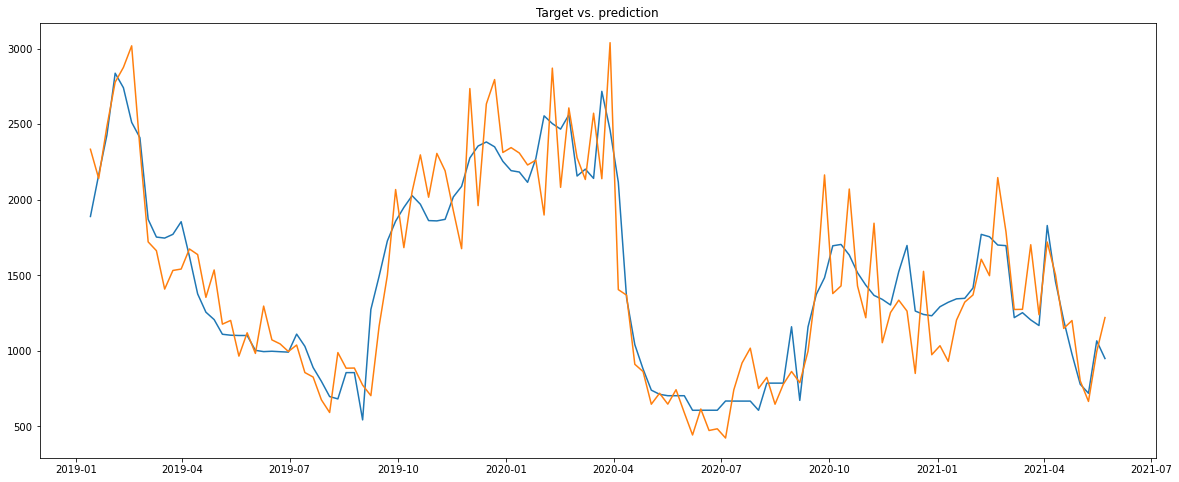

MAPE for training period is:0.15
MAPE for testing period is:0.48
R2 of the training is: 0.84 and, R2 of the testing is: 0.29


In [12]:
# Line chart for performance.
plt.plot(pdf_train.index, lr.predict(X_train),
         pdf_train.index, y_train)
plt.title('Target vs. prediction')
plt.show()

# Compute mean absolute error.
# Actually, we should check for mse since it's what we are optimizing for. 
# However, mape might be a bit more intuitive.
mape_train = np.mean(
    np.abs((y_train - lr.predict(X_train))) / y_train
)
mape_test = np.mean(
    np.abs((y_test - lr.predict(X_test))) / y_test
)
r2_train = round(lr.score(X_train, y_train), 2)
r2_test = round(lr.score(X_test, y_test), 2)
print(f'MAPE for training period is:{np.round(mape_train, 2)}')
print(f'MAPE for testing period is:{np.round(mape_test, 2)}')
print(
    f'R2 of the training is: {r2_train} and,',
    f'R2 of the testing is: {r2_test}'
    )

## 7. Channel contribution.

We observe the marginal channel contribution and the return on investment per channel.

- on site marketing, tv_2 and tv_3 are the biggest sales drivers.
- tv_3 and promotional events seems to be the two most efficients channels.
- tv_1 and on site marketing seems to be inneficient channels (ROI < 1).

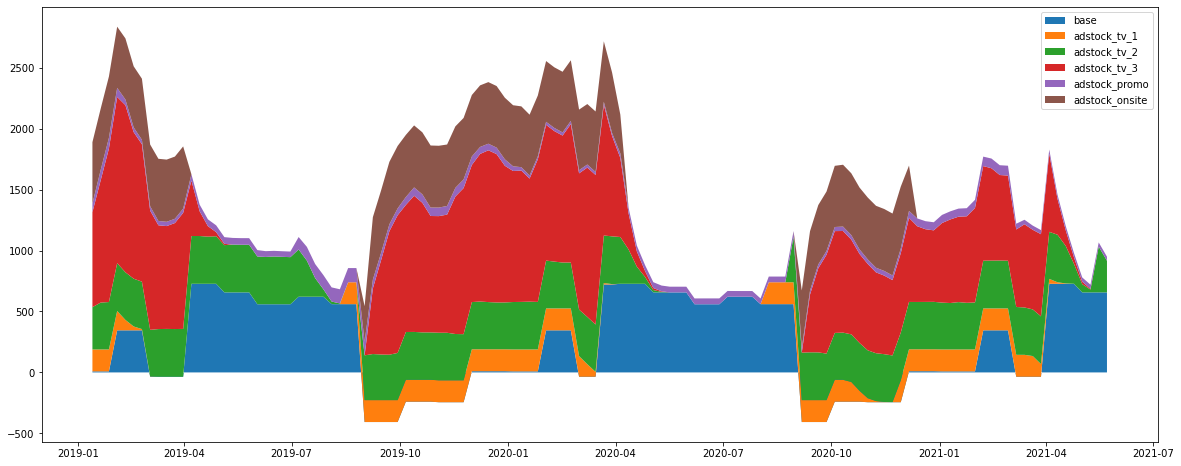

For adstock_tv_1: share of total sales is 0.06 and ROI is 0.39
For adstock_tv_2: share of total sales is 0.21 and ROI is 2.61
For adstock_tv_3: share of total sales is 0.37 and ROI is 34.78
For adstock_promo: share of total sales is 0.04 and ROI is 7.68
For adstock_onsite: share of total sales is 0.16 and ROI is 0.42


In [13]:

# base sales takes into account the intercept plus monthly effects.
base = (
    sum(
        [
            lr.coef_[
                features.index(c)
            ] * X_train.iloc[:, features.index(c)] for c in features if 'adstock' not in c
        ]
    )
      + [lr.intercept_] * len(pdf_train.index))

# Computation of contribution S = B + b1*C1 + b2*C2 
# Cnt_2 = (B+B1*C1+B2*C2) - (B+B1*C1) = B2*C2 

plt.stackplot(
    pdf_train.index, base,
    sales_from('adstock_tv_1', features, lr, X_train),
    sales_from('adstock_tv_2', features, lr, X_train),
    sales_from('adstock_tv_3', features, lr, X_train),
    sales_from('adstock_promo', features, lr, X_train),
    sales_from('adstock_onsite', features, lr, X_train)
)
plt.legend(['base'] + [c for c in features if 'adstock' in c])
plt.show()

# Compute ROI for every channel.
for c in features:
    if 'month' not in c and 'flag' not in c:
        channel_share = np.round(sum(sales_from(c, features, lr, X_train)) / sum(lr.predict(X_train)), 2)
        channel_roi = np.round(sum(sales_from(c, features, lr, X_train)) / sum(pdf_adstock_train[c.replace('adstock_', '')]), 2)
        print(f'For {c}: share of total sales is {channel_share} and ROI is {channel_roi}')

In [37]:
px.bar(
        y=lr.coef_,
        x=X_train.columns,
        title='Contribution bar plot',
        labels={
            "x": "Feature",
            "y": "Contribution"
        }
)


# Discussion 

- Why are some channel contributions negative? Does this make sense from a business POV? 
- Why is TV3's contribution so high? How can we address this?
- What would happen if we try Log or Semi-log models? Would it be worth it?
- Would it be worth it to use another type of model, for example tree-based algorithms?
- What recommendations would you give to business with these results